# This notebook shows how to train a robust inverse of kamera operator

- should accept vector of size 10 of 2D points in camera view (in meters)
- should output a vector of size 6 of camera pose (3D position and 3D rotation)
- should be robust to noise in input
    - it is first trained as a pure inverse of kamera operator (pretrained available in `hot_start.h5`)
    - then it is trained on a dataset of 800k samples obtained as follows:
        - generate position and rotation of camera in feasible domain
        - use kamera operator to generate 2D points
        - add noise to 2D points
        - use minimization in sense of least squares to find camera pose wit least error (Newton's method)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from kamera import kamera  # kamera operator written in Python, equivalent to the one in Matlab

In [2]:
# feasible bounds of camera position and orientation
bounds = np.array([50 * 1e-3, 50 * 1e-3, 50 * 1e-3, 20 * np.pi / 180, 20 * np.pi / 180, 20 * np.pi / 180])

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Neural network architecture

- Perceptron with 3 hidden layers
- activation function: Tanh

In [4]:
def compute_distances_angles_efficient(points):
    n = points.shape[0]  # Number of rows in the input
    reshaped_points = points.reshape(n, 5, 2)  # Reshape to n x 5 x 2 for point coordinates

    # Precompute all distances between points
    def dist(p1, p2): return np.sqrt((p1[:, 0] - p2[:, 0])**2 + (p1[:, 1] - p2[:, 1])**2)
    distances = np.hstack([
        dist(reshaped_points[:, 0], reshaped_points[:, 1]).reshape(-1, 1),  # Distance 1-2
        dist(reshaped_points[:, 1], reshaped_points[:, 2]).reshape(-1, 1),  # Distance 2-3
        dist(reshaped_points[:, 2], reshaped_points[:, 0]).reshape(-1, 1),  # Distance 3-1
        dist(reshaped_points[:, 0], reshaped_points[:, 4]).reshape(-1, 1),  # Distance 1-5
        dist(reshaped_points[:, 4], reshaped_points[:, 1]).reshape(-1, 1),  # Distance 5-2
        dist(reshaped_points[:, 0], reshaped_points[:, 3]).reshape(-1, 1),  # Distance 1-4
        dist(reshaped_points[:, 4], reshaped_points[:, 3]).reshape(-1, 1),  # Distance 5-4
        dist(reshaped_points[:, 3], reshaped_points[:, 2]).reshape(-1, 1)   # Distance 4-3
    ])

    # Using the law of cosines to compute angles for each triangle
    def law_of_cosines(a, b, c): return np.arccos((a**2 + b**2 - c**2) / (2 * a * b))

    angles = np.hstack([
        law_of_cosines(distances[:, 0], distances[:, 2], distances[:, 1]).reshape(-1, 1),  # Angle 1 in triangle 1-2-3
        law_of_cosines(distances[:, 0], distances[:, 1], distances[:, 2]).reshape(-1, 1),  # Angle 2 in triangle 1-2-3
        law_of_cosines(distances[:, 1], distances[:, 2], distances[:, 0]).reshape(-1, 1),  # Angle 3 in triangle 1-2-3
        law_of_cosines(distances[:, 0], distances[:, 3], distances[:, 4]).reshape(-1, 1),  # Angle 1 in triangle 1-2-5
        law_of_cosines(distances[:, 0], distances[:, 4], distances[:, 3]).reshape(-1, 1),  # Angle 2 in triangle 1-2-5
        law_of_cosines(distances[:, 3], distances[:, 4], distances[:, 0]).reshape(-1, 1),  # Angle 5 in triangle 1-2-5
        law_of_cosines(distances[:, 3], distances[:, 5], distances[:, 6]).reshape(-1, 1),  # Angle 1 in triangle 1-5-4
        law_of_cosines(distances[:, 3], distances[:, 6], distances[:, 5]).reshape(-1, 1),  # Angle 5 in triangle 1-5-4
        law_of_cosines(distances[:, 5], distances[:, 6], distances[:, 3]).reshape(-1, 1),  # Angle 4 in triangle 1-5-4
        law_of_cosines(distances[:, 5], distances[:, 2], distances[:, 7]).reshape(-1, 1),  # Angle 1 in triangle 1-4-3
        law_of_cosines(distances[:, 5], distances[:, 7], distances[:, 2]).reshape(-1, 1),  # Angle 4 in triangle 1-4-3
        law_of_cosines(distances[:, 2], distances[:, 7], distances[:, 5]).reshape(-1, 1)   # Angle 3 in triangle 1-4-3
    ])

    output = np.hstack([distances, angles])
    return output

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, bounds, hidden_size=512):
        super(Net, self).__init__()
        self.bounds = torch.tensor(bounds, dtype=torch.float32,device='cuda')  # Convert bounds to a PyTorch tensor
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc1_ret = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc4b = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc8 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.ReLu = nn.ReLU()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.tanh(self.fc4b(x))
        x = self.tanh(self.fc5(x))
        x = self.tanh(self.fc6(x))
        x = self.tanh(self.fc7(x))
        x = self.fc8(x)
        x = x * self.bounds  # Scale the output by the bounds
        return x

# Initialize the model
model = Net(30, 6, bounds, hidden_size=512)

### Optional: load pretrained model
- pretrained model is available in `hot_start.h5` file
- its trained for around 24hours on 4070Rtx GPU
- it is trained on synthetic data generated from feasible domain of camera pose and 2D points obtained from kamera operator

In [6]:
import h5py

# Load the model weights from HDF5 file
with h5py.File('trained_model_weights_9.h5', 'r') as h5file:
    for name, param in model.named_parameters():
        # Ensure the parameter name matches the HDF5 dataset name structure
        param.data.copy_(torch.from_numpy(h5file[name][...]))

## Move model to GPU (if available)


In [7]:
model.to(device)

Net(
  (fc1): Linear(in_features=30, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc4b): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=512, bias=True)
  (fc7): Linear(in_features=512, out_features=512, bias=True)
  (fc8): Linear(in_features=512, out_features=6, bias=True)
  (tanh): Tanh()
  (ReLu): ReLU()
)

# Training on synthetic data as precise inverse of kamera operator

Training in batches of `n` samples:
- generate random feasible camera pose and corresponding 2D points using kamera operator
- split to train and test set
- using Adam optimizer (you can adjust learning rate)
- there is fixed number of epochs with some checks for early stopping (overfitting, and patience)

In [14]:
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.5, line_search_fn='strong_wolfe') # Use the L-BFGS optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001)  # Decrease the learning rate

In [16]:
# def criterion(outputs, y_train_tensor):
#     vals = torch.sum((outputs - y_train_tensor)**6,dim=1)*1e20
#     mask = vals > 0.00001
#     return torch.mean(vals[mask])

def criterion(outputs, y_train_tensor):
    vals = torch.sum((outputs - y_train_tensor)**2, dim=1)**3 * 1e22
    return torch.mean(vals)


def closure():
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    return loss


for trial_sets in range(1000000):
    print(f"Trial set {trial_sets}:")

    n = int(1e5)  # number of samples
    output_data = bounds * (np.random.rand(n, 6) - 0.5) * 2  # generate random camera positions and orientations
    input_data1 = kamera(output_data)  # calculate the corresponding points positions in the image
    input_data2 = compute_distances_angles_efficient(input_data1)
    input_data = np.hstack([input_data1, input_data2])

    # divide the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, random_state=42)

    # Convert data to PyTorch tensors and send to the device (GPU if available)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Train the model without using batches
    num_epochs = 2
    best_loss = np.inf
    patience, trials = 2000, 0

    for epoch in range(num_epochs):
        # Forward pass
        # outputs = model(X_train_tensor)
        # loss = criterion(outputs, y_train_tensor)

        # # Backward and optimize
        # optimizer.zero_grad()
        # loss.backward()
        optimizer.step(closure=closure)

        # Adjust the learning rate based on the loss
        # scheduler.step(loss)

        # Print the loss every 100 epochs
        if (epoch + 1) % 1 == 0:
            with torch.no_grad():
                outputs = model(X_test_tensor)
                loss2 = criterion(outputs, y_test_tensor)
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)

            print('Epoch [{}/{}], Loss: {:.5e}, test Loss reached {:.5e}, min Loss reached {:.5e}, stagnating for {} it.'.format(epoch +
                                                                                                                                    1, num_epochs, loss.item(), loss2.item(), best_loss, trials))
            if loss2.item() > 10 * best_loss:
                print(f"Overfitting detected at epoch {epoch+1}")
                break

        # Early stopping
        # if loss.item() < best_loss:
        #     best_loss = loss.item()
        #     trials = 0
        # else:
        #     trials += 1
        #     if trials >= patience:
        #         print(f'Stopping early at epoch {epoch+1}')
        #         break

Trial set 0:
Epoch [1/2], Loss: 2.27187e+00, test Loss reached 1.71994e+00, min Loss reached inf, stagnating for 0 it.
Epoch [2/2], Loss: 1.87367e+00, test Loss reached 1.63169e+00, min Loss reached inf, stagnating for 0 it.
Trial set 1:
Epoch [1/2], Loss: 2.17026e+00, test Loss reached 1.66116e+00, min Loss reached inf, stagnating for 0 it.
Epoch [2/2], Loss: 1.81175e+00, test Loss reached 1.61149e+00, min Loss reached inf, stagnating for 0 it.
Trial set 2:
Epoch [1/2], Loss: 1.36183e+00, test Loss reached 1.30123e+00, min Loss reached inf, stagnating for 0 it.
Epoch [2/2], Loss: 1.33038e+00, test Loss reached 1.29181e+00, min Loss reached inf, stagnating for 0 it.
Trial set 3:
Epoch [1/2], Loss: 1.95669e+00, test Loss reached 1.53551e+00, min Loss reached inf, stagnating for 0 it.
Epoch [2/2], Loss: 1.79827e+00, test Loss reached 1.52258e+00, min Loss reached inf, stagnating for 0 it.
Trial set 4:
Epoch [1/2], Loss: 1.44972e+00, test Loss reached 8.92147e+00, min Loss reached inf, st

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
#s of the fc1 layer
# Since the model is on GPU, the weights will be on GPU as well
# We need to move them to CPU and convert to numpy for plotting
weights = model.fc1.weight.data.cpu().numpy()

# Plot the weights matrix using imshow
plt.figure(figsize=(10, 10))
plt.imshow(weights, aspect='auto', cmap='viridis')  # You can choose any colormap you like
plt.colorbar()
plt.title('Weights of fc1 Layer')
plt.xlabel('Output Neurons')
plt.ylabel('Input Features')
plt.show()

In [19]:
n = int(1e6)  # number of samples
output_data = bounds * (np.random.rand(n, 6) - 0.5) * 2  # generate random camera positions and orientations
input_data1 = kamera(output_data)  # calculate the corresponding points positions in the image
input_data2 = compute_distances_angles_efficient(input_data1)
input_data = np.hstack([input_data1, input_data2])

# divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.99, random_state=42)

# Convert data to PyTorch tensors and send to the device (GPU if available)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

with torch.no_grad():
    outputs = model(X_test_tensor)
    loss2 = criterion(outputs, y_test_tensor)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.89 GiB. GPU 0 has a total capacity of 10.90 GiB of which 850.25 MiB is free. Including non-PyTorch memory, this process has 9.18 GiB memory in use. Of the allocated memory 6.99 GiB is allocated by PyTorch, and 2.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

0.0011111111111111111

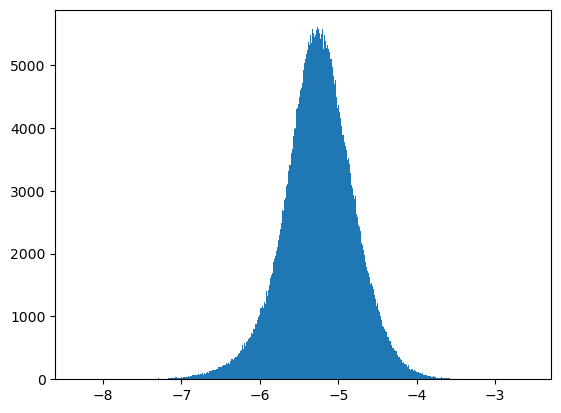

In [18]:
import matplotlib.pyplot as plt

plt.hist(np.log10(np.linalg.norm(X_test_tensor[:,:10].detach().cpu().numpy() - kamera(outputs.detach().cpu().numpy()),axis=1)**2), bins=1000);
np.sum(
    np.log10(
        np.linalg.norm(
            X_test_tensor[:, :10].detach().cpu().numpy() -
            kamera(
                outputs.detach().cpu().numpy()),
            axis=1)**2)>-3)/(n*0.99)*100

In [ ]:
mask = np.log10(
    np.linalg.norm(
        X_test_tensor[:, :10].detach().cpu().numpy() -
        kamera(
            outputs.detach().cpu().numpy()),
        axis=1)**2)>-4
(torch.sum((outputs[mask, :] - y_test_tensor[mask,:])**6,dim=1 )* 1e20).min()

In [ ]:
np.sum(
    np.log10(
        np.linalg.norm(
            X_test_tensor[:, :10].detach().cpu().numpy() -
            kamera(
                outputs.detach().cpu().numpy()),
            axis=1)**2) >-3)

In [ ]:
input_data

In [ ]:
def compute_distances_angles_efficient(points):
    n = points.shape[0]  # Number of rows in the input
    reshaped_points = points.reshape(n, 5, 2)  # Reshape to n x 5 x 2 for point coordinates

    # Precompute all distances between points
    def dist(p1, p2): return np.sqrt((p1[:, 0] - p2[:, 0])**2 + (p1[:, 1] - p2[:, 1])**2)
    distances = np.hstack([
        dist(reshaped_points[:, 0], reshaped_points[:, 1]).reshape(-1, 1),  # Distance 1-2
        dist(reshaped_points[:, 1], reshaped_points[:, 2]).reshape(-1, 1),  # Distance 2-3
        dist(reshaped_points[:, 2], reshaped_points[:, 0]).reshape(-1, 1),  # Distance 3-1
        dist(reshaped_points[:, 0], reshaped_points[:, 4]).reshape(-1, 1),  # Distance 1-5
        dist(reshaped_points[:, 4], reshaped_points[:, 1]).reshape(-1, 1),  # Distance 5-2
        dist(reshaped_points[:, 0], reshaped_points[:, 3]).reshape(-1, 1),  # Distance 1-4
        dist(reshaped_points[:, 4], reshaped_points[:, 3]).reshape(-1, 1),  # Distance 5-4
        dist(reshaped_points[:, 3], reshaped_points[:, 2]).reshape(-1, 1)   # Distance 4-3
    ])

    # Using the law of cosines to compute angles for each triangle
    def law_of_cosines(a, b, c): return np.arccos((a**2 + b**2 - c**2) / (2 * a * b))

    angles = np.hstack([
        law_of_cosines(distances[:, 0], distances[:, 2], distances[:, 1]).reshape(-1, 1),  # Angle 1 in triangle 1-2-3
        law_of_cosines(distances[:, 0], distances[:, 1], distances[:, 2]).reshape(-1, 1),  # Angle 2 in triangle 1-2-3
        law_of_cosines(distances[:, 1], distances[:, 2], distances[:, 0]).reshape(-1, 1),  # Angle 3 in triangle 1-2-3
        law_of_cosines(distances[:, 0], distances[:, 3], distances[:, 4]).reshape(-1, 1),  # Angle 1 in triangle 1-2-5
        law_of_cosines(distances[:, 0], distances[:, 4], distances[:, 3]).reshape(-1, 1),  # Angle 2 in triangle 1-2-5
        law_of_cosines(distances[:, 3], distances[:, 4], distances[:, 0]).reshape(-1, 1),  # Angle 5 in triangle 1-2-5
        law_of_cosines(distances[:, 3], distances[:, 5], distances[:, 6]).reshape(-1, 1),  # Angle 1 in triangle 1-5-4
        law_of_cosines(distances[:, 3], distances[:, 6], distances[:, 5]).reshape(-1, 1),  # Angle 5 in triangle 1-5-4
        law_of_cosines(distances[:, 5], distances[:, 6], distances[:, 3]).reshape(-1, 1),  # Angle 4 in triangle 1-5-4
        law_of_cosines(distances[:, 5], distances[:, 2], distances[:, 7]).reshape(-1, 1),  # Angle 1 in triangle 1-4-3
        law_of_cosines(distances[:, 5], distances[:, 7], distances[:, 2]).reshape(-1, 1),  # Angle 4 in triangle 1-4-3
        law_of_cosines(distances[:, 2], distances[:, 7], distances[:, 5]).reshape(-1, 1)   # Angle 3 in triangle 1-4-3
    ])

    output = np.hstack([distances, angles])
    return output


def plot_points_with_enhanced_details(points, computed_results):
    """
    Enhances the previous function to plot points with distances and angles annotated, including lines for each triangle
    and shifting angle text towards the center of each triangle for better clarity.

    Parameters:
    - points: An array of points' positions.
    - computed_results: An array of computed distances and angles.
    """
    plt.figure(figsize=(10, 8))

    # Plot points and label them
    for i, point in enumerate(points):
        plt.plot(point[0], point[1], 'o', label=f'Point {i+1}')
        plt.text(point[0], point[1], f' P{i+1}', verticalalignment='bottom', horizontalalignment='right', fontsize=9)

    # Annotate distances
    distances = computed_results[0, :8]  # First 8 are distances
    distance_pairs = [(0, 1), (1, 2), (2, 0), (0, 4), (4, 1), (0, 3), (4, 3), (3, 2)]
    for i, pair in enumerate(distance_pairs):
        p1, p2 = points[pair[0]], points[pair[1]]
        mid_point = (p1 + p2) / 2
        plt.text(mid_point[0], mid_point[1], f'{distances[i]:.2f}', color='blue', fontsize=9, ha='center')

    # Draw lines for each triangle and annotate angles
    triangles = [(0, 1, 2), (0, 1, 4), (0, 4, 3), (0, 3, 2)]
    angles = computed_results[0, 8:]  # Angles
    angle_idx = 0  # Index to access angles array
    for triangle in triangles:
        # Calculate triangle centroid for angle text placement
        centroid = np.mean(points[list(triangle)], axis=0)
        for i in range(3):
            # Draw lines
            p1, p2 = points[triangle[i]], points[triangle[(i + 1) % 3]]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'g--', alpha=0.75)  # Triangle lines

            # Annotate angles, slightly shifted towards centroid
            angle_pos = points[triangle[i]] + (centroid - points[triangle[i]]) * 0.2
            plt.text(angle_pos[0], angle_pos[1], f'{angles[angle_idx]:.3f} rad', color='red', fontsize=9, ha='center')
            angle_idx += 1

    plt.title('Enhanced Points with Distances and Angles')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()



In [ ]:

results = compute_distances_angles_efficient(input_data)
# Using the enhanced function with the previous points and computed results
plot_points_with_enhanced_details(input_data[2, :].reshape(5, -1), results[2, :].reshape(1, -1))


# Replicating the input to form an n x 10 matrix and test the corrected function

results[0, :8], results[0, 8:]  # Displaying the first row's distances and angles as an example

In [ ]:
input_data[0,:]

# Training on noisy data

## Load noisy data (and their optimal camera pose as Least squares solution)

In [ ]:
# load matlab saved file noisy_data.mat and print what variables are in it
import scipy.io
mat = scipy.io.loadmat('noisy_data.mat')

# create torch dataloader on the noisy data its synth_x_best as the output and synth_y_test as the input
input_data_noisy = torch.tensor(mat['synth_y_test'], dtype=torch.float32)
output_data_noisy = torch.tensor(mat['synth_x_best'], dtype=torch.float32)
dataloader = DataLoader(TensorDataset(input_data_noisy, output_data_noisy), batch_size=10000, shuffle=True)

## Training on batches of `n` samples of noisy data

- recomended to use smaller number of epochs and repeat whole proces multiple times with adjusted learning rate

In [ ]:
for batch_input, batch_output in dataloader:

    X_train, X_test, y_train, y_test = train_test_split(batch_input, batch_output, test_size=0.1, random_state=42)

    # Convert data to PyTorch tensors and send to the device (GPU if available)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Define the loss function and the optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # Decrease the learning rate

    # Add a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)

    # Train the model without using batches
    num_epochs = 100000
    best_loss = np.inf
    patience, trials = 5000, 0

    for epoch in range(num_epochs):
        # Ensure the entire dataset is on the same device as the model

        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Adjust the learning rate based on the loss
        scheduler.step(loss)

        if epoch % 100 == 0:
            outputs = model(X_test_tensor)
            loss2 = criterion(outputs, y_test_tensor)
            print('Epoch [{}/{}], Loss: {:.10f}, test Loss reached {:.10f}, min Loss reached {:.10f}, stagnating for {} it.'.format(epoch +
                1, num_epochs, loss.item(),loss2.item(), best_loss, trials))
            if loss2.item() > 10*best_loss:
                print(f"Overfitting detected at epoch {epoch+1}")
                break

        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            trials = 0
        else:
            trials += 1
            if trials >= patience:
                print(f'Stopping early at epoch {epoch+1}')
                break

# Save the trained model to h5 file

In [80]:
import h5py

# If your model is on CUDA, move it back to CPU
model.to('cpu')

# Save model parameters to HDF5, including biases
with h5py.File('trained_model_weights_10.h5', 'w') as h5file:
    for name, param in model.state_dict().items():
        h5file.create_dataset(name, data=param.numpy())